In [42]:

"""
# File to plot the (projected) size of the catalogue over the next 20 years
"""
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from astropy.table import Table, vstack
import astropy.units as u
from astropy import constants as const
import pandas as pd

##############################
# Add public O4a data from GraceDB
from ligo.gracedb.rest import GraceDb

# First convert the GWTC3 rates to yr^-1
from astropy.cosmology import WMAP9 as cosmology
import scipy
import scipy.integrate

######################################
## PLOT setttings
plt.rc('font', family='serif')
from matplotlib import rc
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)
fsize, SMALL_SIZE, MEDIUM_SIZE, BIGGER_SIZE = 30,25,25,30
for obj in ['axes','xtick','ytick']:
    plt.rc(obj, labelsize=MEDIUM_SIZE)          # controls default text sizes
for obj in ['figure','axes']:
    plt.rc(obj, titlesize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize



# First log all the observed GW events

Data was queried from [the GW-openscience portal](https://www.gw-openscience.org/eventapi/)
where we used 'GWTC-1-confident', 'GWTC-2.1-confident' and 'GWTC-3-confident'


In [159]:
# Combine the three catalogues
GWTC1 = Table.read('data/GWTC1_confident.csv', delimiter=',')
GWTC2 = Table.read('data/GWTC2_1_confident.csv', delimiter=',')
GWTC3 = Table.read('data/GWTC3_confident.csv', delimiter=',')
GWTC4 = Table.read('data/GWTC4.csv', delimiter=',')
GWTC_all = vstack([GWTC1, GWTC2, GWTC3, GWTC4])

GWTC_all['obs_date_yr'] = np.full(len(GWTC_all), 0.)

# Assign flavours to the mergers
GWTC_all['flavour'] = np.full(len(GWTC_all), 'BHBH')
BHNS_names = ['GW190917_114630', 'GW191219_163120', 'GW200115_042309', 'GW200210_092254', 'GW230518_125908'] #GW190814 = sketch
NSNS_names = ['GW170817','GW190425']

# Correct the flavours and add the date
for i, name in enumerate(GWTC_all['commonName']):
    
    if name in BHNS_names:
        GWTC_all['flavour'][i] = 'BHNS'
    if name in NSNS_names:
        GWTC_all['flavour'][i] = 'NSNS'
        
    # change name to date
    year  = float(GWTC_all['commonName'][i][2:4])
    month = float(GWTC_all['commonName'][i][4:6])
    day   = float(GWTC_all['commonName'][i][6:8])
    GWTC_all['obs_date_yr'][i] = 2000 + year + (month-1)/12. + day/365.25 

        
print( len(GWTC_all[GWTC_all['flavour'] == 'NSNS']))
print(len(GWTC_all[GWTC_all['flavour'] == 'BHNS']))
print(len(GWTC_all[GWTC_all['flavour'] == 'BHBH']))

# print(GWTC_all.info())

#############################
# Add public O4b data from GraceDB
# from ligo.gracedb.rest import GraceDb
# Create a GraceDb client
client = GraceDb()

# Fetch public O4b events using 'runid: O4b' query
# runid: O4b constrains GPS time to O4b range (1396796418 to 1422118818)
# Query syntax: space-separated terms work as AND
events = client.superevents('public runid: O4b far < 1e-9') 

O4b_count = 0
for event in events:
    year = int(event['superevent_id'][1:3])
    month = int(event['superevent_id'][3:5])
    day = int(event['superevent_id'][5:7])
    obs_date_yr = 2000 + year + (month-1)/12. + day/365.25 
    
    print('obs_date_yr',obs_date_yr, 'superevent_id:', event['superevent_id'])
    # Create a new row for O4b event
    new_row = {
        'obs_date_yr': obs_date_yr,
        'flavour': 'BHBH',
        'commonName': event['superevent_id'],
        'far': event['far']
    }
    # Append the new row to the GWTC_all Table
    GWTC_all.add_row(new_row)
    O4b_count += 1

print(f'\nTotal O4b events retrieved from GraceDB: {O4b_count}')

#############################
# Add public O4c data from GraceDB
# Fetch public O4c events using 'runid: O4c' query
# runid: O4c constrains GPS time to O4c range (1422118818 to 1447516818)
events_O4c = client.superevents('public runid: O4c far < 1e-9') 

O4c_count = 0
for event in events_O4c:
    year = int(event['superevent_id'][1:3])   # Get 2 digits for year
    month = int(event['superevent_id'][3:5])  # Get 2 digits for month
    day = int(event['superevent_id'][5:7])    # Get 2 digits for day
    obs_date_yr = 2000 + year + (month-1)/12. + day/365.25 
    
    print('obs_date_yr',obs_date_yr, 'superevent_id:', event['superevent_id'])
    # Create a new row for O4c event
    new_row = {
        'obs_date_yr': obs_date_yr,
        'flavour': 'BHBH',
        'commonName': event['superevent_id'],
        'far': event['far']
    }
    # Append the new row to the GWTC_all Table
    GWTC_all.add_row(new_row)
    O4c_count += 1

print(f'\nTotal O4c events retrieved from GraceDB: {O4c_count}')

print(GWTC_all.info())

# Manually log the end dates of the Observing runs:
end_O1 = 2016 + (1-1)/12. +19./365.25 # 19 January 2016
end_O2 = 2017 + (8-1)/12. +25./365.25 # 25 August 2017
end_O3 = 2020 + (3-1)/12. +27./365.25 # 27 March 2020
end_O4a = 2024 + (1-1)/12. + 17/365.25 # 17 Jan 2024 
end_O4b = 2025 + (5-1)/12. + 27/365.25 # 27 May 2025 (approximate O4b end)
end_O4c = 2025 + (12-1)/12. + 31/365.25 # 31 Dec 2026 (approximate O4c end)

print(GWTC_all['obs_date_yr'].min(), GWTC_all['obs_date_yr'].max())


2
5
212
obs_date_yr 2025.0520191649555 superevent_id: S250119cv
obs_date_yr 2025.0520191649555 superevent_id: S250119ag
obs_date_yr 2025.0492813141684 superevent_id: S250118dp
obs_date_yr 2025.0492813141684 superevent_id: S250118t
obs_date_yr 2025.03832991102 superevent_id: S250114ax
obs_date_yr 2025.024640657084 superevent_id: S250109f
obs_date_yr 2025.021902806297 superevent_id: S250108eo
obs_date_yr 2025.0109514031485 superevent_id: S250104v
obs_date_yr 2025.0015400410678 superevent_id: S241231bg
obs_date_yr 2024.9988021902807 superevent_id: S241230bd
obs_date_yr 2024.985112936345 superevent_id: S241225v
obs_date_yr 2024.985112936345 superevent_id: S241225c
obs_date_yr 2024.9440451745381 superevent_id: S241210cw
obs_date_yr 2024.9154688569472 superevent_id: S241130be
obs_date_yr 2024.9154688569472 superevent_id: S241130n
obs_date_yr 2024.9127310061601 superevent_id: S241129aa
obs_date_yr 2024.9072553045858 superevent_id: S241127aj
obs_date_yr 2024.9045174537987 superevent_id: S24112

In [162]:
# Number of events in O4b and O4c:
end_O4b = 2025 + (5-1)/12. + 27/365.25 # 27 May 2025 (approximate O4b end)
print('O4a BHNS events:', len(GWTC_all[(GWTC_all['obs_date_yr'] > end_O3) & (GWTC_all['obs_date_yr'] <= end_O4a) & (GWTC_all['flavour'] == 'BHNS')]))
print('O4b BHNS events:', len(GWTC_all[(GWTC_all['obs_date_yr'] > end_O4a) & (GWTC_all['obs_date_yr'] <= end_O4b) & (GWTC_all['flavour'] == 'BHNS')]))
print('O4c BHNS events:', len(GWTC_all[(GWTC_all['obs_date_yr'] > end_O4b) & (GWTC_all['flavour'] == 'BHNS')]))

print('O4c BBH events:', len(GWTC_all[(GWTC_all['obs_date_yr'] > end_O4b) & (GWTC_all['flavour'] == 'BHBH')]))
print('O4b BBH events:', len(GWTC_all[(GWTC_all['obs_date_yr'] > end_O4a) & (GWTC_all['obs_date_yr'] <= end_O4b) & (GWTC_all['flavour'] == 'BHBH')]))
print('Total O4b+O4c BBH events:', len(GWTC_all[(GWTC_all['obs_date_yr'] > end_O4a) & (GWTC_all['flavour'] == 'BHBH')]))

# Print total O4 events
print('Total O4 BBH events:', len(GWTC_all[GWTC_all['obs_date_yr'] > end_O3]) )

O4a BHNS events: 1
O4b BHNS events: 0
O4c BHNS events: 0
O4c BBH events: 35
O4b BBH events: 80
Total O4b+O4c BBH events: 115
Total O4 BBH events: 244


# Upcoming gravitational wave detectors

|     Name                 |     Dates                                                           |     DR dates                                                                                              |     frequency            |     Citation                                                                                                                                        |
|--------------------------|---------------------------------------------------------------------|-----------------------------------------------------------------------------------------------------------|--------------------------|-----------------------------------------------------------------------------------------------------------------------------------------------------|
|     O4                   |     May 2023 – Dec 2024                                             |    O4b = summer 2026                  |     10 Hz to 10 kHz      |     https://observing.docs.ligo.org/plan/                                                                                                           |
|     O5                   |     2027 - 2030                                                     |     O5a = ? jan2029 ?     O5b = ? June 2032?                                                              |     10 Hz to 10 kHz      |     https://observing.docs.ligo.org/plan/                                                                                                           |
|     Voyager              |     2028–2038.      (10   years continuous operation)               |                                                                                                           |     10 – 10 kHz ?        |     https://ui.adsabs.harvard.edu/abs/2020CQGra..37p5003A/abstract     https://dcc.ligo.org/public/0113/T1400316/004/T1400316-v5.pdf                |
|     DECIGO               |     2030-ies                                                        |                                                                                                           |     10^-3 - 100 Hz       |     https://ui.adsabs.harvard.edu/abs/2006CQGra..23S.125K/abstract                                                                                  |
|     LISA                 |     2037 – 2041 or 2047      4 year   mission + 6 year extension    |     Athena-LISA synnergy                                                                                  |     1e-5 – 1 Hz          |     https://ui.adsabs.harvard.edu/abs/2019CQGra..36j5011R/abstract                                                                                  |
|     TianQin              |     2030-ies                                                        |                                                                                                           |     10^-4 - 10^-1 Hz     |     https://ui.adsabs.harvard.edu/abs/2016CQGra..33c5010L/abstract                                                                                  |
|     Big Bang Observer    |     (2025??)      Post   LISA                                       |     (fills gap between ligo and lisa)                                                                     |     0.1 – 1 Hz           |     https://ui.adsabs.harvard.edu/abs/2006CQGra..23.2435C/abstract                                                                                  |
|     ET                   |     2035                                                            |                                                                                                           |     1 to 10 kHz          |     https://ui.adsabs.harvard.edu/abs/2020JCAP...03..050M/abstract                                                                                  |
|     CE                   |     Later half of 2030-ies                                          |                                                                                                           |     5 Hz to 3.75 kHz?    |     https://arxiv.org/abs/1907.04833                                                                                                                |
|     PTA                  |     e.g. SKA                                                        |     SKA first light 2027            International   Pulsar Timing Array   = (PPTA, EPTA, and NANOGrav)    |     10^-9 - 10^-6 Hz     |     https://ui.adsabs.harvard.edu/abs/2015CQGra..32a5014M/abstract           https://ui.adsabs.harvard.edu/abs/2019PhRvD.100j4028H/abstract         |




***


In [163]:
# Use pandas to read excel file
df = pd.read_excel('data/FutureDetectors.xlsx', header =0, 
                   sheet_name = 'Gravitational wave observations')
# pour it into Astropy table
GW_missions = Table.from_pandas(df)

# #######################
# # Manually add GW 04 b
# O4b =  GW_missions[GW_missions['Name'] == 'O4'].copy()
# O4b['Name'] = 'O4b'
# O4b['mission_start_year']  = 2024
# O4b['mission_start_month'] = 11
# O4b['mission_end_year']  = 2025
# O4b['mission_end_month'] = 6

# GW_missions = vstack([GW_missions, O4b])

# Add some extra columns
GW_missions['mission_start']   = GW_missions['mission_start_year'] + (GW_missions['mission_start_month']-1)/12.
GW_missions['mission_end']     = GW_missions['mission_end_year'] + (GW_missions['mission_end_month']-1)/12.
GW_missions['mid_mission']     = (GW_missions['mission_start'] + GW_missions['mission_end'])/2.
GW_missions['freq_center'] = (GW_missions['freq_end']  + GW_missions['freq_start'])/2.


display(GW_missions)

# Add SKA-era PTAs “Square-Kilometre-Array” (SKA) (e.g. Terzian & Lazio 2006).
#     Phase 1: Providing ~10% of the total collecting area at low and mid frequencies by 2023 (SKA1).[29]
#     Phase 2: Completion of the full array (SKA2) at low and mid frequencies by 2030.[30]
# 70 Months From July 01, 2021  = May 01, 2027 
# souce https://www.skao.int/en/science-users/159/scientific-timeline
SKADR = Table()

SKADR['name']  = ['SKA2']#'SKA1', 
SKADR['year']  = [2029]#2021, 
SKADR['month'] = [5]#7,   
SKADR['date']  = SKADR['year'] + (SKADR['month']-1)/12.
SKADR['opt_freq']     = GW_missions['opt_freq'][GW_missions['Name'] == 'PTA'] 





Name,mission_start_year,mission_start_month,mission_end_year,mission_end_month,freq_start,freq_end,opt_freq,DR dates,Citation,Notes,mission_start,mission_end,mid_mission,freq_center
str7,int64,int64,int64,int64,float64,float64,float64,str84,str126,str61,float64,float64,float64,float64
O4,2023,5,2024,11,10.0,10000.0,200.0,"O4a = oct 2025. (DR = 18 months after end of 6 month obs block), O4b = may 2026",https://observing.docs.ligo.org/plan/,--,2023.3333333333333,2024.8333333333333,2024.0833333333333,5005.0
O5,2027,1,2029,6,10.0,10000.0,200.0,"O5a = ? jan2029 ?, O5b = ? June 2032?",https://observing.docs.ligo.org/plan/,--,2027.0,2029.4166666666667,2028.2083333333335,5005.0
Voyager,2030,1,2035,1,10.0,5000.0,40.0,--,"https://ui.adsabs.harvard.edu/abs/2020CQGra..37p5003A/abstract, https://dcc.ligo.org/public/0113/T1400316/004/T1400316-v5.pdf",10 years cont. operation,2030.0,2035.0,2032.5,2505.0
DECIGO,2037,1,2040,1,0.001,100.0,0.3,--,https://ui.adsabs.harvard.edu/abs/2006CQGra..23S.125K/abstract,"start = ""2030-ies""",2037.0,2040.0,2038.5,50.0005
LISA,2037,1,2041,1,1e-05,1.0,0.003,--,https://ui.adsabs.harvard.edu/abs/2019CQGra..36j5011R/abstract,4 year mission + 6 year extension (note Athena-LISA synnergy),2037.0,2041.0,2039.0,0.500005
TianQin,2037,1,2040,1,0.0001,1.0,0.1,--,https://ui.adsabs.harvard.edu/abs/2016CQGra..33c5010L/abstract,"start = ""2030-ies""",2037.0,2040.0,2038.5,0.50005
ET,2038,1,2045,1,1.0,10000.0,100.0,--,"https://ui.adsabs.harvard.edu/abs/2020JCAP...03..050M/abstract, https://www.et-gw.eu/",--,2038.0,2045.0,2041.5,5000.5
CE,2038,1,2045,1,5.0,3750.0,50.0,--,https://arxiv.org/abs/1907.04833,--,2038.0,2045.0,2041.5,1877.5
PTA,2020,1,2045,1,1e-09,1e-06,1e-08,"SKA first light 2027, International Pulsar Timing Array = (PPTA, EPTA, and NANOGrav)","https://ui.adsabs.harvard.edu/abs/2015CQGra..32a5014M/abstract ,https://ui.adsabs.harvard.edu/abs/2019PhRvD.100j4028H/abstract",--,2020.0,2045.0,2032.5,5.005e-07


# Detection rate 
To estimate the number of events for future observation runs, we need some yearly detection rate which we can  multiply by the mission length


## For O4 and O5
The Summary Statistics from Ligos 'Observing Capabilities' webpage: 
https://emfollow.docs.ligo.org/userguide/capabilities.html#datadrivenexpectations

quote the Sensitive volume ( = detection rate / merger rate)
and Merger rate for all three flavours (BBH, BHNS, NSNS) for O4 and O5, including 5% to 95% confidence intervals.

the detection rate = Sensitive volume * merger rate

## For Voyager, the Einstein telescope, and Cosmic explorer

both values below are for S/N > 10

The network name "VK+HLIv" corresponds to "three LIGO detectors (HLI) operating with Voyager technology in addition to A+ versions of Virgo and KAGRA."
The network name "ECS" corresponds to a network containing ET, CE-North, and CE-South.

#### BBH and NSNS
Table IV from  [Borhanian & Sathyaprakash 2022](https://arxiv.org/pdf/2202.11048.pdf) lists detection rate per year BBH and NSNS mergers  
They assume the following rates [NSNS, BHBH] = [4.7 * 10^5, 1.2 * 10^5] $yr^{-1}$


#### BHNS
Table IV. from [Gupta et al. 2023](https://ui.adsabs.harvard.edu/abs/2023arXiv230108763G/abstract)
list the detection rate for BHNS

They assume the following rates [NSBH] = [4*10^4] $yr^{-1}$  (up to z = 20)


Alternative: Tables 4, 5, and 3 [Iacovelli et al. 2022](https://ui.adsabs.harvard.edu/abs/2022ApJ...941..208I/abstract) 
future_detections['ET_detection_rate'] = [40107, 29707, 69799] # N/yr


# Estimates of cosmic rate
from the [pop GWTC3 paper](https://arxiv.org/abs/2111.03634)
Using the _redshift independent rates_!

NSNS merger rate = $10 - 1700 \mathrm{Gpc^{−3}yr^{−1}}$ \
BHNS merger rate = $7.8 - 140 \mathrm{Gpc^{−3}yr^{−1}}$ \
BBH merger  rate = $16 – 61 \mathrm{Gpc^{−3}yr^{−1}}$ \
(at z=0.2, R_BBH = 17.9- 44)


Combining this with the 'volume' of the Universe up to z=20 we can use this to re-scale the detection rates from other works
E.g. 


In [164]:
# Use the LIGO rates to propagate the rate error to the detection rate
# First convert the GWTC3 rates to yr^-1
import scipy.integrate

from astropy.cosmology import WMAP9 as cosmology
redshifts = 20
# convert redshifts to volumnes and ensure all volumes are in Gpc^3
volumes = cosmology.comoving_volume(redshifts).to(u.Gpc**3).value
print(volumes)

# LVK obs [min, max] Rates per year
NSNS_rates_yr = [10 *volumes, 1700*volumes]
BHNS_rates_yr = [7.8 *volumes, 140*volumes]
BHBH_rates_yr = [16 *volumes, 61*volumes]

print(NSNS_rates_yr, BHNS_rates_yr, BHBH_rates_yr)

# Detection_rate_scaled  =  (Rate_LIGO/Rate_paper) * Detection_rate_paper
NSNS_scale_fact = [NSNS_rates_yr[0]/(4.7*1e5), NSNS_rates_yr[1]/(4.7*1e5)] #rate from Borhanian & Sathyaprakash
BHNS_scale_fact = [BHNS_rates_yr[0]/(4e4), BHNS_rates_yr[1]/(4e4)] # Gupta
BHBH_scale_fact = [BHBH_rates_yr[0]/(1.2*1e5), BHBH_rates_yr[1]/(1.2*1e5)]#rate from Borhanian & Sathyaprakash

print(NSNS_scale_fact[1], BHNS_scale_fact[0])



5619.610618229717
[np.float64(56196.10618229717), np.float64(9553338.05099052)] [np.float64(43832.962822191796), np.float64(786745.4865521603)] [np.float64(89913.76989167547), np.float64(342796.24771201273)]
20.326251172320255 1.0958240705547948


In [165]:
future_detections = Table()

future_detections['flavour'] = ['NSNS', 'BHNS', 'BHBH']

# cosmic merger rates
future_detections['cosmic_merger_rate_min']  = [10,  7.8, 16 ] # Gpc^-3 yr^-1
future_detections['cosmic_merger_rate_max']  = [1700,140, 61 ] # Gpc^-3 yr^-1


# O4 
# the detection rate = Sensitive volume * merger rate
future_detections['O4_Sensitive_vol']  = [0.172, 0.78, 15.15] # N/yr
future_detections['O4_detection_rate_min'] = future_detections['O4_Sensitive_vol'] * future_detections['cosmic_merger_rate_min'] # N/yr
future_detections['O4_detection_rate_max'] = future_detections['O4_Sensitive_vol'] * future_detections['cosmic_merger_rate_max']  # N/yr

future_detections['O4_detection_rate'] = [0.172 * 210 ,0.78  * 8.6, 15.15 * 17.1] # N/yr

# O4 
# the detection rate = Sensitive volume * merger rate
future_detections['O5_Sensitive_vol'] = [0.827, 3.65 , 50.7]  # N/yr
future_detections['O5_detection_rate_min'] = future_detections['O5_Sensitive_vol'] * future_detections['cosmic_merger_rate_min'] # N/yr
future_detections['O5_detection_rate_max'] = future_detections['O5_Sensitive_vol'] * future_detections['cosmic_merger_rate_max']  # N/yr


future_detections['O5_detection_rate'] = [0.827 * 210, 3.65 * 8.6, 50.7 * 17.1]  # N/yr

# Voyager 
# table IV from [Borhanian & Sathyaprakash 2022], and Table IV. from [Gupta et al. 2023]
future_detections['Voyager_detection_rate'] = [1800, 5.7*1e3 ,31000] # N/yr

future_detections['Voyager_detection_rate_min'] = future_detections['Voyager_detection_rate'] * [NSNS_scale_fact[0], BHNS_scale_fact[0], BHBH_scale_fact[0]] # N/yr
future_detections['Voyager_detection_rate_max'] = future_detections['Voyager_detection_rate'] * [NSNS_scale_fact[1], BHNS_scale_fact[1], BHBH_scale_fact[1]] # N/yr


# ET/CE network (just using 'ET' to represent ECS network)
# BBH, NSNS: Borhanian & Sathyaprakash 2022, BHNS: Table IV. from [Gupta et al. 2023]
future_detections['ET_detection_rate'] = [2.7*1e5, 3.9*1e4, 1.2*1e5] # N/yr

future_detections['ET_detection_rate_min'] = future_detections['ET_detection_rate'] * [NSNS_scale_fact[0], BHNS_scale_fact[0], BHBH_scale_fact[0]] # N/yr
future_detections['ET_detection_rate_max'] = future_detections['ET_detection_rate'] * [NSNS_scale_fact[1], BHNS_scale_fact[1], BHBH_scale_fact[1]] # N/yr

# Iacovelli et al. 2022 Tables 4, 5, and 3
# future_detections['ET_detection_rate'] = [40107, 29707, 69799] # N/yr


display(future_detections)


flavour,cosmic_merger_rate_min,cosmic_merger_rate_max,O4_Sensitive_vol,O4_detection_rate_min,O4_detection_rate_max,O4_detection_rate,O5_Sensitive_vol,O5_detection_rate_min,O5_detection_rate_max,O5_detection_rate,Voyager_detection_rate,Voyager_detection_rate_min,Voyager_detection_rate_max,ET_detection_rate,ET_detection_rate_min,ET_detection_rate_max
str4,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
NSNS,10.0,1700,0.172,1.7199999999999998,292.4,36.12,0.827,8.27,1405.8999999999999,173.67,1800.0,215.2191300598615,36587.25211017646,270000.0,32282.869508979224,5488087.816526469
BHNS,7.8,140,0.78,6.084,109.2,6.708,3.65,28.47,511.0,31.389999999999997,5700.0,6246.1972021623305,112111.23183368285,39000.0,42737.138751636994,767076.8493883563
BHBH,16.0,61,15.15,242.4,924.15,259.06500000000005,50.7,811.2,3092.7000000000003,866.9700000000001,31000.0,23227.72388868283,88555.69732560328,120000.0,89913.76989167547,342796.24771201273


In [174]:
colors = ['#1a1a1a', '#d3838b', '#f7bf8a']
colors = ['#4f6d7a', '#ef5b5b', '#ffba49']
#4f6d7a
#20a39e

# Darken color 
def darken_color(hex_color, factor=0.7):
    """
    Darken a hex color by multiplying RGB values by a factor.
    
    Parameters:
    -----------
    hex_color : str
        Hex color code (e.g., '#9ecc5e')
    factor : float
        Darkening factor (0-1). Lower values = darker.
        Default 0.7 darkens by 30%.
    
    Returns:
    --------
    str
        Darkened hex color code
    """
    hex_color = hex_color.lstrip('#')
    r, g, b = tuple(int(hex_color[i:i+2], 16) for i in (0, 2, 4))
    r, g, b = tuple(int(c * factor) for c in (r, g, b))
    return '#{:02x}{:02x}{:02x}'.format(r, g, b)

end_previous 2025.8798767967146 period[0] 2027.0
end_previous 2029.4199999999978 period[0] 2030.0
end_previous 2034.9999999999955 period[0] 2038.0
end_previous 2023.3826146475017 period[0] 2027.0
end_previous 2029.4199999999978 period[0] 2030.0
end_previous 2034.9999999999955 period[0] 2038.0
end_previous 2019.3184462696784 period[0] 2027.0
end_previous 2029.4199999999978 period[0] 2030.0
end_previous 2034.9999999999955 period[0] 2038.0
end_date 2016.0520191649555
end_date 2017.6517796030116
end_date 2020.2405886379192
end_date 2024.0465434633813


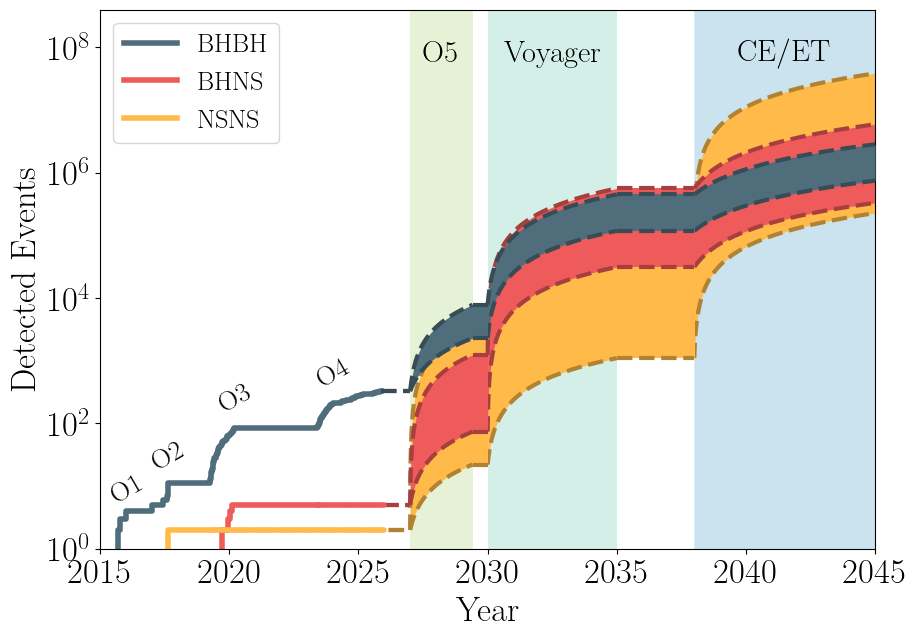

In [175]:
fig, ax = plt.subplots(figsize = (10,7))


dt     = 0.01 # timestep in year
linewid= 3

GW_missions.sort('mission_start')


##########################
# Loop over the three flavours
for f, flavour in enumerate(['BHBH', 'BHNS', 'NSNS']):

    ##########################
    # Past detections
    flav_tab = GWTC_all[GWTC_all['flavour'] == flavour]
    flav_tab.sort('obs_date_yr')
    
    # Duplicate first row 
    flav_tab = vstack([flav_tab[0], flav_tab])

    # N is also the cumsum
    detected_events = np.arange(len(flav_tab)) 

    # Plot cumulative sum of events
    plt.step(flav_tab['obs_date_yr'], detected_events,
             color = colors[f], lw = linewid+1, label = "$\mathrm{%s}$"%(flavour) )
    
    # For BHNS and NSNS, extend solid line through end of O4c (nothing detected)
    if flavour in ['BHNS', 'NSNS']:
        plt.plot([flav_tab['obs_date_yr'][-1], end_O4c], [detected_events[-1], detected_events[-1]],
                 color = colors[f], lw = linewid+1, label = None, solid_capstyle='round', zorder = 4)
    
    end_previous    = flav_tab['obs_date_yr'][-1]
    events_previous_min = detected_events[-1]
    events_previous_max = detected_events[-1]
    
    ##########################
    # Near Future detectors (just using ET to represent ECS network)
    for detector in ['O5', 'Voyager', 'ET']:  #'O4b',
        detection_rate_min = future_detections[detector + '_detection_rate_min'][future_detections['flavour'] == flavour]
        detection_rate_max = future_detections[detector + '_detection_rate_max'][future_detections['flavour'] == flavour]
        
        # Use smooth time stepping for the observing period 
        period = np.arange(GW_missions['mission_start'][GW_missions['Name'] == detector][0], GW_missions['mission_end'][GW_missions['Name'] == detector][0] +dt, dt )
        time_steps  = np.full(len(period), dt) # an array filled with n times dt

        # Calculate the min number of detections (cumsum) during this run
        N_events_min   = detection_rate_min * time_steps
        N_events_min[0]= events_previous_min # start where you ended in the previous line
        new_events_min = np.cumsum(N_events_min)
        
        # Calculate the max number of detections (cumsum) during this run
        N_events_max   = detection_rate_max * time_steps
        N_events_max[0]= events_previous_max # start where you ended in the previous line
        new_events_max = np.cumsum(N_events_max)
                
        # plot it
        print('end_previous',end_previous, 'period[0]',period[0] )
        plt.fill_between(period, y1 = new_events_min, y2 = new_events_max, zorder = 3-f, lw = 0,
                         color = colors[f], label = None, alpha = 1)
        
        plt.plot(period, new_events_min, color = darken_color(colors[f]), ls = '--',
                 lw = linewid, label = None, solid_capstyle='round',zorder = 3-f)

        plt.plot(period, new_events_max, color = darken_color(colors[f]), ls = '--',
                 lw = linewid, label = None, solid_capstyle='round',zorder = 3-f)
                

        #########################
        # Connection piece    
        plt.fill_between((end_previous, period[0]+(5/365.25)), y1 = events_previous_min, y2 = events_previous_max, lw=0,
                         interpolate=True, zorder = 3-f, color = colors[f], label = None, alpha = 1)
        
        plt.plot((end_previous, period[0]),(events_previous_min, events_previous_min), 
                 color = darken_color(colors[f]), lw = linewid, ls = '--', label = None,zorder = 3-f )
        plt.plot((end_previous, period[0]),(events_previous_max, events_previous_max),
                 color = darken_color(colors[f]), lw = linewid, ls = '--', label = None,zorder = 3-f )

        
        end_previous    = period[-1]#end[0]
        events_previous_min = new_events_min[-1]
        events_previous_max = new_events_max[-1]
        

##########################
# Label the past missions
for i, end_date in enumerate([end_O1, end_O2, end_O3, end_O4a]):
    print('end_date',end_date)
    BBH_tab = GWTC_all[GWTC_all['flavour'] == 'BHBH']
    N_det = len(BBH_tab[BBH_tab['obs_date_yr'] <=  end_date])
    # plt.vlines(end_date, ymin=0, ymax = N_det *1.8, lw = 0.1, color = 'k')
    plt.text(end_date, N_det*1.8, '$\mathrm{O %s}$'%(i+1), 
             ha = 'center', fontsize = 20, rotation = 30 )
    
##########################
# Label the future missions
CEET_col = '#2c93bf'
space_col = '#029656'
voy_col = '#53C2A3'
O4b_col = '#9ecc5e'
O5_col = '#9ecc5e' #change
PTA_col = '#d1c54f'
mission_colors = [PTA_col, O4b_col, O5_col, voy_col, space_col,space_col,space_col, CEET_col, CEET_col]
#
for detector in ['O5', 'Voyager', 'ET']: 
    mission = GW_missions[GW_missions['Name'] == detector]
    period = np.arange(mission['mission_start'][0], mission['mission_end'][0] + dt, dt )
    # There are more missions in the table than I show (this keeps color consistent)
    mis_i = np.where(GW_missions['Name'] == detector)[0][0]
    # Change the label name shown for ET/CE network
    if detector == 'ET':
        detector = 'CE/ET' 
        
    plt.text(GW_missions['mid_mission'][mis_i], 6e7, '$\mathrm{%s}$'%(detector), 
             ha = 'center', fontsize = 22 )
    plt.fill_between(period, y1 = 0, y2 = 4e8, facecolor = mission_colors[mis_i], # N 3e7
                     alpha = 0.25, zorder = 0, lw = 0.1 )
    # plt.fill_between(period, y1 = 3e7, y2 = 4e8, color = mission_colors[mis_i], alpha = 0.7)


##########################
# Plotvalues
plt.xlim(2015, 2045)
plt.ylim(1e0, 4e8)
plt.yscale('log')

plt.xlabel('$\mathrm{Year}$')
plt.ylabel('$\mathrm{Detected \ Events}$')
plt.legend(loc = 'upper left', fontsize = 19)
# plt.savefig('SizeOfCatalogue_err.pdf', bbox_inches='tight', transparent=True)

plt.show()



end_date 2016.0520191649555
end_date 2017.6517796030116
end_date 2020.2405886379192
end_date 2024.0465434633813


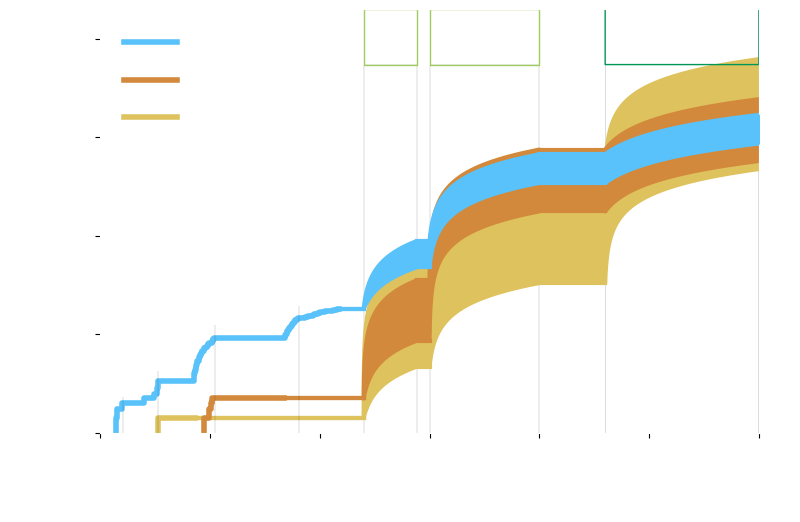

In [179]:
fig, ax = plt.subplots(figsize = (8.5,11/2.), facecolor='none')
ax.set_facecolor('none')

# Use explicit styling for athis figure: set white colors for labels/ticks/legend/text
colors = ['#59C2FA', '#D3893B', '#dec25d']
dt     = 0.01 # timestep in year
linewid= 3

GW_missions.sort('mission_start')

##########################
# Loop over the three flavours
for f, flavour in enumerate(['BHBH', 'BHNS', 'NSNS']):
#     if f == 0: 
#         continue
    ##########################
    # Past detections
    flav_tab = GWTC_all[GWTC_all['flavour'] == flavour]
    flav_tab.sort('obs_date_yr')
    
    # Duplicate first row 
    flav_tab = vstack([flav_tab[0], flav_tab])

    # N is also the cumsum
    detected_events = np.arange(len(flav_tab)) 


    # Plot cumulative sum of events
    plt.step(flav_tab['obs_date_yr'], detected_events,
             color = colors[f], lw = linewid+1, label = "$\\mathrm{%s}$"%(flavour) )
    
    end_previous    = flav_tab['obs_date_yr'][-1]
    events_previous_min = detected_events[-1]
    events_previous_max = detected_events[-1]
    
    ##########################
    # Near Future detectors (just using ET to represent ECS network)
    for detector in ['O5', 'Voyager', 'ET']: #'O4', 
        detection_rate_min = future_detections[detector + '_detection_rate_min'][future_detections['flavour'] == flavour]
        detection_rate_max = future_detections[detector + '_detection_rate_max'][future_detections['flavour'] == flavour]
        
        # Use smooth time stepping for the observing period 
        period = np.arange(GW_missions['mission_start'][GW_missions['Name'] == detector][0], GW_missions['mission_end'][GW_missions['Name'] == detector][0] +dt, dt )
        time_steps  = np.full(len(period), dt) # an array filled with n times dt

        # Calculate the min number of detections (cumsum) during this run
        N_events_min   = detection_rate_min * time_steps
        N_events_min[0]= events_previous_min # start where you ended in the previous line
        new_events_min = np.cumsum(N_events_min)
        
        # Calculate the miax number of detections (cumsum) during this run
        N_events_max   = detection_rate_max * time_steps
        N_events_max[0]= events_previous_max # start where you ended in the previous line
        new_events_max = np.cumsum(N_events_max)
                
        # plot it
        plt.fill_between(period, y1 = new_events_min, y2 = new_events_max, zorder = 3-f, 
                         edgecolor = colors[f], facecolor = colors[f], label = None)
        
        plt.plot(period, new_events_min, color = colors[f], ls = '-',
                 lw = linewid, label = None, solid_capstyle='round',zorder = 3-f)
        plt.plot(period, new_events_max, color = colors[f], ls = '-',
                 lw = linewid, label = None, solid_capstyle='round',zorder = 3-f)
                

        ##########################
        # Connection piece        
        plt.fill_between((end_previous, period[0]), y1 = events_previous_min, y2 = events_previous_max, 
                         interpolate=True, zorder = 3-f, facecolor = colors[f], label = None)
        
        plt.plot((end_previous, period[0]),(events_previous_min, events_previous_min), 
                 color = colors[f], lw = linewid, label = None,zorder = 3-f )
        plt.plot((end_previous, period[0]),(events_previous_max, events_previous_max),
                 color = colors[f], lw = linewid, label = None,zorder = 3-f )

        
        end_previous    = period[-1]#end[0]
        events_previous_min = new_events_min[-1]
        events_previous_max = new_events_max[-1]
        

##########################
# Label the past missions
for i, end_date in enumerate([end_O1, end_O2, end_O3, end_O4a]):
    print('end_date',end_date)
    BBH_tab = GWTC_all[GWTC_all['flavour'] == 'BHBH']
    N_det = len(BBH_tab[BBH_tab['obs_date_yr'] <=  end_date])
    plt.vlines(end_date, ymin=0, ymax = N_det *1.8, lw = 0.1, color = 'k')
    plt.text(end_date, N_det*1.8, '$\\mathrm{O %s}$'%(i+1), 
             ha = 'center', fontsize = 20, rotation = 30 )

##########################
# Label the future missions
CEET_col = '#2c93bf'
space_col = '#029656'
voy_col = '#53C2A3'
O4a_col = '#9ecc5e'
O4b_col = '#9ecc5e'
O5_col = '#9ecc5e' #change
PTA_col = '#d1c54f'
mission_colors = [PTA_col, O4a_col, O4b_col, O5_col, voy_col, space_col,space_col,space_col, CEET_col, CEET_col]
#
for detector in ['O5', 'Voyager', 'ET']: 
    mission = GW_missions[GW_missions['Name'] == detector]
    period = np.arange(mission['mission_start'][0], mission['mission_end'][0] + dt, dt )
    # There are more missions in the table than I show (this keeps color consistent)
    mis_i = np.where(GW_missions['Name'] == detector)[0][0]
    # Change the label name shown for ET/CE network
    if detector == 'ET':
        detector = 'CE/ET' 
        
    plt.text(GW_missions['mid_mission'][mis_i], 6e7, '$\\mathrm{%s}$'%(detector), 
             ha = 'center', fontsize = 22 )
    plt.fill_between(period, y1 = 0, y2 = 3e7, edgecolor = 'k', facecolor = 'none',
                     zorder = 0, lw = 0.1 )
    plt.fill_between(period, y1 = 3e7, y2 = 4e8, edgecolor = mission_colors[mis_i], facecolor = 'none')


##########################
# Plotvalues
plt.xlim(2015, 2045)
plt.ylim(1e0, 4e8)
plt.yscale('log')

plt.xlabel('$\\mathrm{Year}$')
plt.ylabel('$\\mathrm{Detected \\ Events}$')
leg = ax.legend(loc = 'upper left', fontsize = 19)

# Force explicit white coloring for this axis and its text elements (avoids relying on rcParams)
ax.xaxis.label.set_color('white')
ax.yaxis.label.set_color('white')
for tl in ax.get_xticklabels() + ax.get_yticklabels():
    tl.set_color('white')

# Axis spines
for spine in ax.spines.values():
    spine.set_edgecolor('white')

# Legend text and frame
if leg is not None:
    for text in leg.get_texts():
        text.set_color('white')
    leg.get_frame().set_edgecolor('white')
    leg.get_frame().set_facecolor('none')

# Any plt.text calls added above
for t in ax.texts:
    t.set_color('white')

# Save transparent PDF
plt.savefig('SizeOfCatalogue_err_blackbg.pdf', bbox_inches='tight', transparent=True, facecolor='none')

plt.show()
